In [1]:
import numpy as np
from numpy import pi, sqrt, log, log10, cos, sin
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
import numpy as np
from typing import Optional, Tuple
from lvmc.core.particle_lattice import ParticleLattice, Orientation
from lvmc.core.magnetic_field import MagneticField
from lvmc.core.flow import PoiseuilleFlow
from enum import Enum, auto
from typing import NamedTuple, List, Optional
import json
import h5py

from lvmc.core.simulation import Simulation
from lvmc.data_handling.data_collector import DataCollector
from lvmc.data_handling.data_exporter import DataExporter
from tqdm import tqdm
from utils import *
from rich import print
import sys

import time
from IPython.display import display, clear_output

Using device: cpu


In [2]:
# Parameters for ParticleLattice                                                                                                           
width = 50
height = 25
v0 = 100.0
density = 0.3

seed = 3179 
def read_lattice(t0, tmax, g, v0, v1):
    flow_params = {"type": "poiseuille", "v1": v1}
    if flow_params["v1"] == 0:
        dt_flow = 2*tmax
        mydir = "file_output/" 
        base_name = "noflow_"+str(width)+"_"+str(height)+"_"+str(g)+"_"+str(v0).removesuffix('.0') 
    else:
        dt_flow = 0.1/flow_params["v1"]
        mydir = "file_output/" 
        base_name = flow_params["type"]+"_"+str(width)+"_"+str(height)+"_"+str(g)+"_"+str(v0).removesuffix('.0')+"_"+str(flow_params["v1"]).removesuffix('.0')

    fname_stats = "stat_"+base_name+"seed%d"%(seed)+".txt"
    dt_stat = 0.1
    dt_dump_stat = 5
    dt_dump_field = 50

    # Initialize the Simulation (test if restart of not)                                                                                   
    if t0==0:
        print("Starting simulation from scratch with g = %g, v1 = %g" % (g,flow_params["v1"]))
        simulation = Simulation(g, v0, width=width, height=height, density=density, flow_params=flow_params, with_transport=False)
        obstacles = torch.zeros((height, width), dtype=torch.bool)
        obstacles[0, :] = True
        obstacles[-1, :] = True
        simulation.lattice.set_obstacles(obstacles)
    else:
        fname =  mydir+"fields_"+base_name+"_"+("%1.2f"%(t0-dt_dump_field))+"_"+("%1.2f"%t0)+"seed%d"%(seed)+".h5"
        simulation = Simulation.init_from_file(fname)
    data_collector = DataCollector(simulation)
    
    return simulation.lattice

In [20]:
#lattice visualization 
for t in range(200,500,50):
    clear_output(wait=True)
    lattice = read_lattice(t0 = t, tmax = 500, g = 1.6, v0 = 100., v1 = 20.)
    print(lattice.visualize_lattice())
    time.sleep(1)

Initializing simulation from file file_output/fields_poiseuille_50_25_1.6_100_20_400.00_450.00seed3179.h5
Simulation with Poiseuille flow


■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■
· · · · · · · · ↓ · · → · · · · · · · · · · · · · · · · · · · · · · · · ↓ · ← · · ↑ ↓ · · · · · · ·
· · · · · · · · → · · · · · · · · · · · · · ↓ · · · · · · · · · · · · · → ↓ · · · · · · · · · · · ·
· · · · · · · · · · · · · · · · · · · ↓ · · · · ↑ · · ← · · ← · · · ↓ · ← · · · · · · · · → · · · ·
· · ↓ · ↑ ← · · · · · · · · · · · · · ↑ · · · · · · · · · · · · · · ↑ · · · · · · · · ↓ · · · ← · ·
· · · ↑ ↑ ↑ · · · · · · · · · · · · · · · · · → ↑ · · · · · · · · · ↑ · · · · · · · ↓ · · · · ↑ · ·
· · · · ↑ · ↓ · · · · · · · ↑ · · · · ↓ ← · · · · · · · · · · · · · · ↑ · · · · · · · · ↓ · · · · ·
· · · · · · · · · · · · · · · · · · · · · ↓ · · · · · · · · · ↑ ↑ ↑ · · · · ↑ · · · · · → ↓ · · · ·
· · · · ↓ → · · · ↓ ↓ · · · ↓ · · · → · · · ↓ · · · · · · · · → → → → ↓ · · · · · · ← · → ← ↓ · · ·
→ · → ↓ ↓ ↓ · · · · · · · → · → · · → ↓ · · · · · ↓ · → ↓ · · · → ↑ ← · · · · ↓ · · ↓ · ↑ · · → · →
→ · → → ↓ ↓ ↓ ↓ ↓ · · · → → ↓ · · → → → → → · → → → → → ↓ → ↓ ↓ · · · → · · → → → → → ↑ ↓ · · → → →
→ → → → → → → ↓ → → → → → → → → → → → ↑ · → → → → → → → ↓ ↓ ↓ → → → → → → → · ↑ → → → · → → → → · →
→ → → ↑ → → → → → → → → → → → → → → → → → → → → → → → → → → → → → → → → → ↑ ↑ ↑ · → → → → → → → → →
→ → → → ↑ ↑ · · → → · · → → → → → → → → → → → → → → → → ↑ ↑ · → → → → → → ↑ ↑ · · · → → → → → → → →
↑ → · · → → · → → → → → → → → · · · · · · → → · · · ↑ ↑ · · ↓ · · · · · · · · · → ↑ ↑ · · → → · → ·
· · · · · ↑ · · · ↑ · ↑ ↑ → · → · · · · · → → ↑ · · · · · · · · · ↑ · · · · · · · ↑ ← · · · · · · ·
· · · · · · · · · · · · · ↓ ↑ · · · · · · · ↑ · · · · · · · · → → · · · · · · · · · · · · · · · · ·
· ← · · ↑ · · · · · ↓ ← · · · · · · · · · · · · · · · · · · ↑ · · · · · · · · · · · · · · · · · · ·
· · · · · · · · · ← · · · · · · → · · · · · · · · · · · · · · · · · ↓ · · · · · · · · · · · · · ← ·
· · · ← · · · · · · · · · · · · · · · · · ↑ · · · · · · ↑ · ← · · · · · · · ↓ · · · · · · · ↑ · · ·
· · → · → · · · · · ← ↑ · · · · · · · · · · · · · · ← · ↑ · · · · · · · → · · ↓ · · · · · · → ↑ · ·
· · · · · · · · · · · · · · · · · · ↑ · · · · · · · · · · · · · · · · · · ↓ · ↓ · · ↑ ↓ · · ↓ · · ·
· · · · · · · · · · ↓ · → · ↓ · · · · · · · · · · · · · · · · · · · · · · ↑ ↓ → → ↓ · ↑ ← · · · · ·
· → · · · · · · · ↓ · · · · · · · ↓ · ← · · · · · · · · · · · · · · ← · · · ↑ ↑ ↑ · · · · → · · · ·
■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ ■

trasformo lattice in binario:

Initializing simulation from file file_output/fields_poiseuille_50_25_1.6_100_20_400.00_450.00seed3179.h5
Simulation with Poiseuille flow


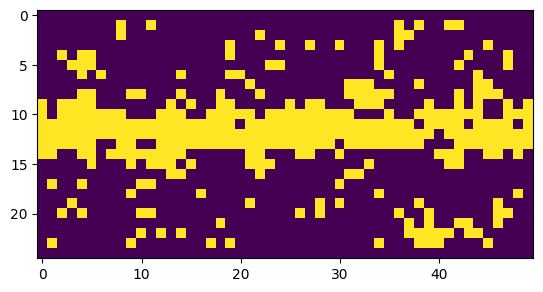

In [17]:
#lattice visualization 
for t in range(200,500,50):
    clear_output(wait=True)
    lattice = read_lattice(t0 = t, tmax = 500, g = 1.6, v0 = 100., v1 = 20.)
    data = torch.sum(lattice.particles, axis = 0)
    plt.imshow(data)
    #print(lattice.visualize_lattice())
    plt.show()
    time.sleep(1)


# CLUSTERING

In [57]:
'''
    Apply hierarchical clustering on 1D/2D arrays. Clustering functionality is provided
    by the SciPy package.
'''
sim_params_dict = 0
width = 50
height = 25

from copy import copy
from scipy.cluster.hierarchy import linkage, fcluster
import numpy as np
from BFS import connected_components
import numpy as np
from numpy import pi, sqrt, log, log10, cos, sin
import matplotlib.pyplot as plt
import matplotlib

# Define a Custom Distance Function including periodic boundary conditions for the x direction 
def periodic_distance_x(s1, s2, width): 
    dx = np.abs(s1[1] - s2[1])
    dy = np.abs(s1[0] - s2[0])
    
    # Apply periodic boundary conditions only along the x direction
    if dx > width / 2:
        dx = width - dx
    
    return dx + dy #np.sqrt(dx**2 + dy**2)

# Calculate the Distance Matrix
def calculate_distance_matrix_x(points, width):
    n = len(points)
    distance_matrix = np.zeros((n, n))
    
    for i in range(n):
        for j in range(i+1, n):
            distance_matrix[i, j] = periodic_distance_x(points[i], points[j], width)
            distance_matrix[j, i] = distance_matrix[i, j]
    
    return distance_matrix

def detect_clusters(data, dendrogram_cutoff, method='single'):
    '''
        Binarize numerical data, and then run hierarchical clustering on it.

        Turn the input data into 0's and 1's by global thresholding; say, that N 1's
        are produced as a result. Then, interpreting the array indexes of the 1's as
        Euclidean coordinates, run hierarchical clustering on them. In machine learning
        terms, the clustering procedure is applied to N observations, each with (at most)
        2 features.

        In the end, return a N-by-3 numpy array. The columns record X,Y coordinates
        and the (integer) id of the cluster, to which this point is assigned.
        Assumption for 2D arrays: origin at top left corner.

        Args:
            data: 1D or 2D numpy array, containing positions
            method: clustering linkage used
            dendrogram_cutoff: cut-off for cluster-merging distance, applied to linkage matrix
        Returns:
            HCStats: a N-by-3 numpy array recording the clustering output

        For additional documentation of SciPy's hierarchical clustering routines,
        see https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/
        and the official documentation @ https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html
    '''

    # Assume already binarized; find directly occupied coordinates
    #occupied_pts = np.transpose(np.nonzero(data))
    occupied_pts = (np.nonzero(data))  

    print(np.shape(occupied_pts))
    dim = np.shape(occupied_pts)[1]
    if dim == 1:
        X = occupied_pts[:,0]
        Y = np.zeros(X.shape)
    elif dim == 2:
        X = occupied_pts[:,1]
        Y = occupied_pts[:,0]
    else:
        raise NotImplementedError("Function designed to handle only 1D/2D data. Higher\
        dimensions are not yet allowed.")

    # Calculate the full distance matrix
    distance_matrix = calculate_distance_matrix_x(occupied_pts, width)

    # Convert to condensed distance matrix
    condensed_distance_matrix = distance_matrix[np.triu_indices(len(occupied_pts), k=1)]

    
    # Generate linkage matrix, which describes the iterative clustering steps
    # And then, identifiy each point with a cluster
    linkage_matrix = linkage(condensed_distance_matrix, method=method)
    clusters = fcluster(linkage_matrix, dendrogram_cutoff, criterion="distance")
    clusters = clusters - 1. # Broadcasted substraction; change to zero-base index

    # Engineering the feature matrix
    # Columns: (X coordinate, Y coordinate, cluster id)
    # Casting to integer; saves space with no loss of information
    HCStats = np.stack((X,Y,clusters), axis = 1)
    return linkage_matrix, HCStats.astype(np.int32)

torch.Size([345, 2])

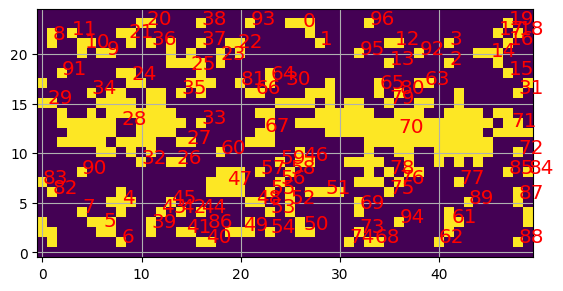

/var/folders/jw/ms6nwqhj4kq7txdm8lyhcqy80000gn/T/ipykernel_17278/2217134572.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  my_cmap = matplotlib.cm.get_cmap('jet')


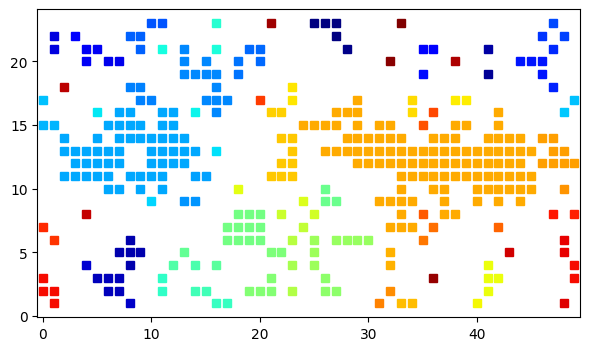

total number of clusters = 97

average size of clusters = 3.5567 std = 11.2341

[  4   1   1   1   5   5   1   1   2   2   3   1   2   1   4   1   1   1
   1   1   2   3   3   2   4  12   2   2  52   2   2   1   1   1   1   1
   1   1   1   2   2   2   1   1   1   1   3  11   2   4   3   4   3   1
   1   1   1   1   1   1   1   4   1   2   2   2   2   8   2   2 100   8
   1   1   1   1   1   1   1   1   1   1   1   1   1   1   6   2   1   1
   1   1   1   1   1   1   1]

Text(0, 0.5, 'histogram')

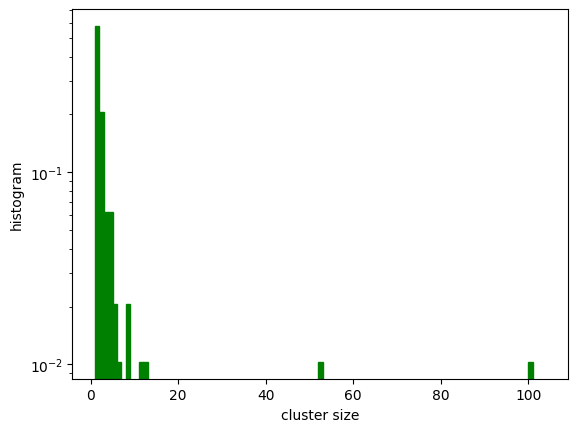

In [162]:
cutoff = 1.1 
data = torch.sum(lattice.particles, axis = 0)
''' Perform hierarchical clustering '''
linkage_matrix, HCStats = detect_clusters(data=data, method='single', dendrogram_cutoff=cutoff)


###### cluster-label visualization

plt.imshow(data, origin='lower')
plt.grid()
cluster_ids = HCStats[:,-1]
for cluster in np.unique(cluster_ids):
    X = HCStats[cluster_ids == cluster, 0]
    Y = HCStats[cluster_ids == cluster, 1]
    label_X = np.mean(X); label_Y = np.mean(Y)
    plt.text(x=label_X, y=label_Y, s="{}".format(cluster), color='red', fontsize='x-large')

plt.show()

###### cluster color map visualization

data_mX = HCStats[:,0]
data_mY = HCStats[:,1]
cluster_ids = HCStats[:,2]

my_cmap = matplotlib.cm.get_cmap('jet')

plt.figure(figsize = (7,4))

for i in range(data_mX.shape[0]):
    col = my_cmap(cluster_ids[i]/(max(cluster_ids)))
    plt.plot(data_mX[i], data_mY[i],'s', color = col)
plt.xlim(-0.5,49.5)
plt.show()

###### cluster statistics visualization

unique_cluster_ids, sizes = np.unique(HCStats[:,-1], return_counts=True)
print('total number of clusters = %d \n' %(len(unique_cluster_ids)))
print('average size of clusters = %g std = %g \n' %(np.mean(sizes), np.std(sizes)))

#distirbution of clusters size > threshold
mask = ((sizes > 0))
print(mask * sizes)
bins = (np.arange(1,max(sizes)+5, 1))
hist, bins, = np.histogram(mask * sizes, bins = bins, density = True)
#plt.plot(bins[:-1], hist, 'o-')
plt.hist((mask * sizes), bins = bins, density = True, edgecolor = 'g', facecolor = 'g')
#plt.xscale('log')
plt.yscale('log')
plt.xlabel ('cluster size')
plt.ylabel('histogram')

LOOP over time:

Initializing simulation from file file_output/fields_poiseuille_50_25_1.6_100_20_0.00_50.00seed3179.h5
Simulation with Poiseuille flow


torch.Size([345, 2])

/var/folders/jw/ms6nwqhj4kq7txdm8lyhcqy80000gn/T/ipykernel_17278/3595331557.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  my_cmap = matplotlib.cm.get_cmap('gist_ncar')


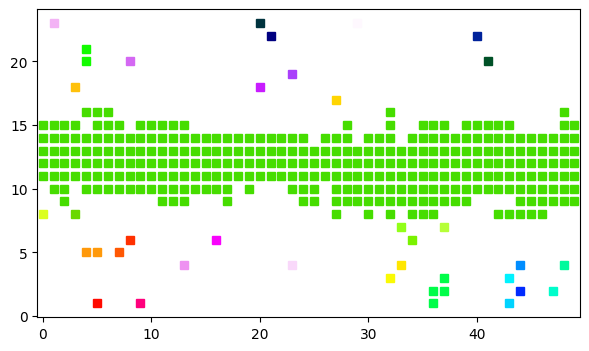

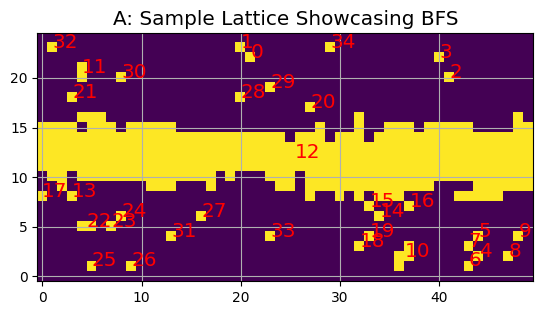

total number of clusters = 35

average size of clusters = 9.85714 std = 50.791

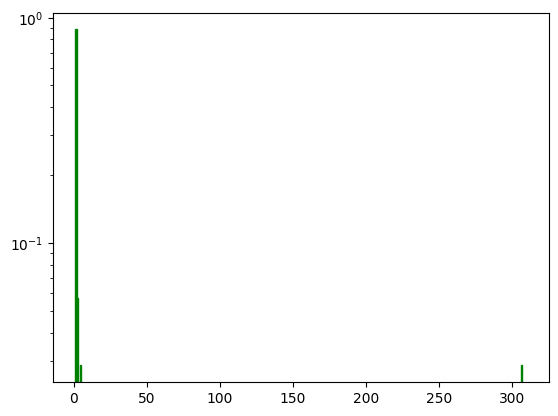

Initializing simulation from file file_output/fields_poiseuille_50_25_1.6_100_20_50.00_100.00seed3179.h5
Simulation with Poiseuille flow


torch.Size([345, 2])

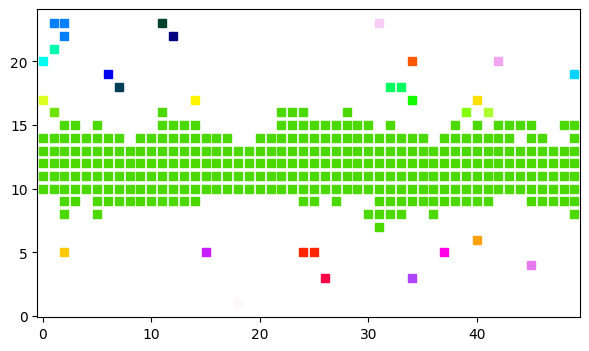

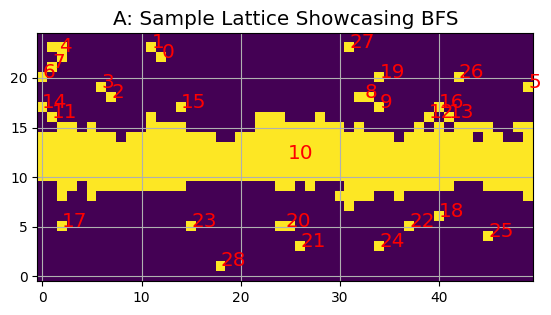

total number of clusters = 29

average size of clusters = 11.8966 std = 56.9048

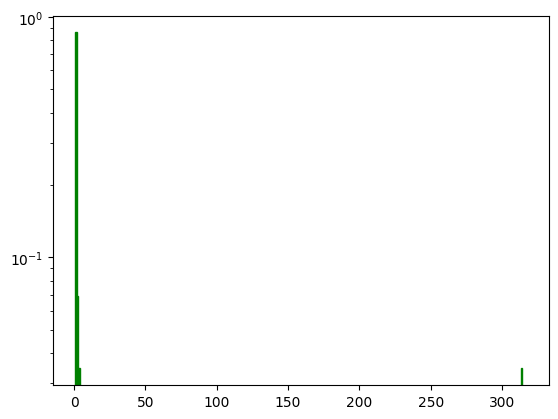

Initializing simulation from file file_output/fields_poiseuille_50_25_1.6_100_20_100.00_150.00seed3179.h5
Simulation with Poiseuille flow


torch.Size([345, 2])

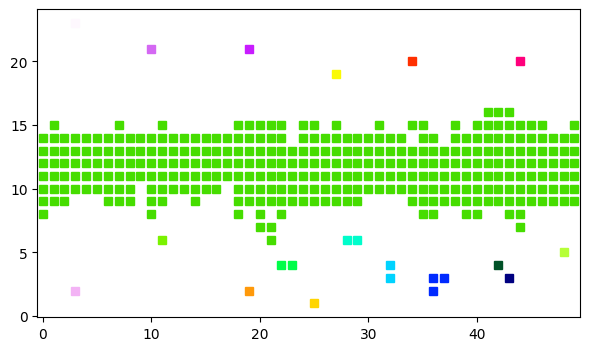

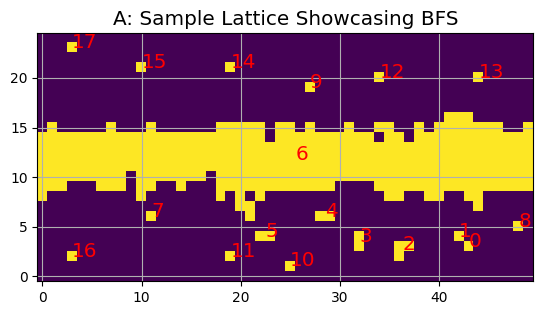

total number of clusters = 18

average size of clusters = 19.1667 std = 73.6925

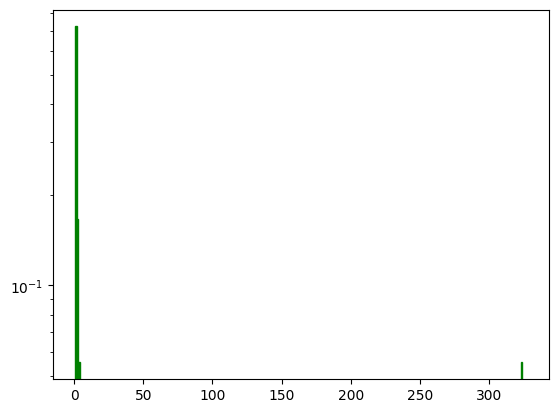

Initializing simulation from file file_output/fields_poiseuille_50_25_1.6_100_20_150.00_200.00seed3179.h5
Simulation with Poiseuille flow


torch.Size([345, 2])

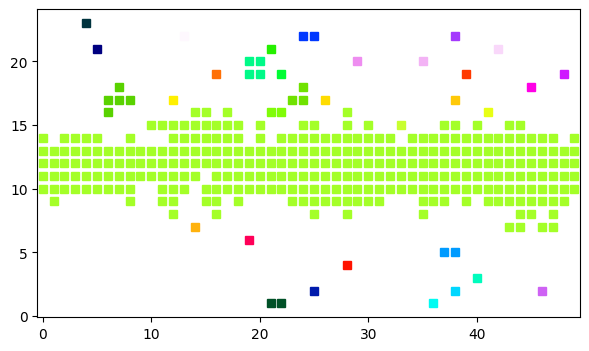

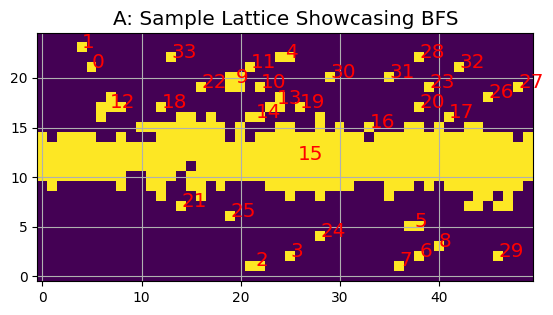

total number of clusters = 34

average size of clusters = 10.1471 std = 50.291

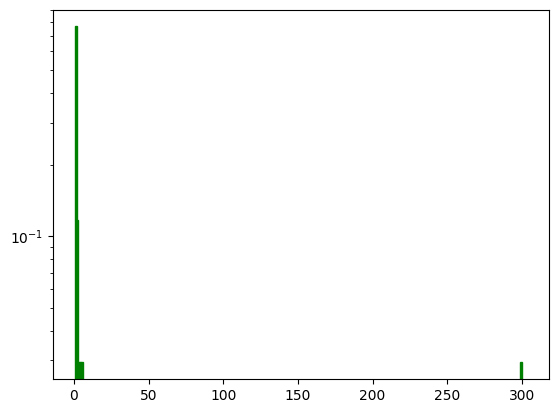

Initializing simulation from file file_output/fields_poiseuille_50_25_1.6_100_20_200.00_250.00seed3179.h5
Simulation with Poiseuille flow


torch.Size([345, 2])

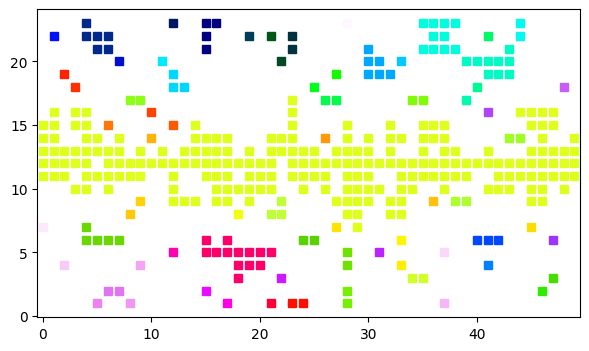

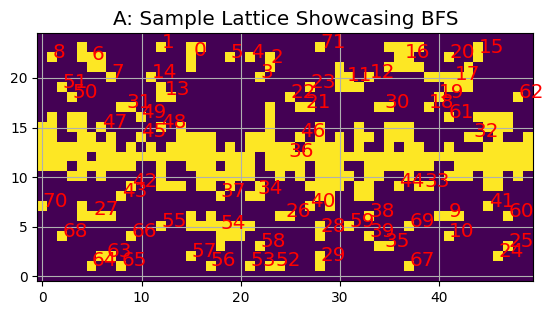

total number of clusters = 72

average size of clusters = 4.79167 std = 24.3293

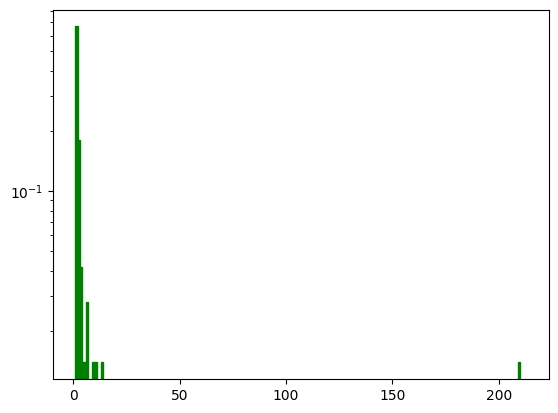

Initializing simulation from file file_output/fields_poiseuille_50_25_1.6_100_20_250.00_300.00seed3179.h5
Simulation with Poiseuille flow


torch.Size([345, 2])

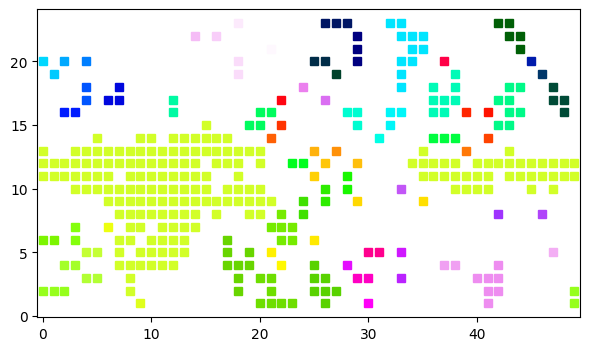

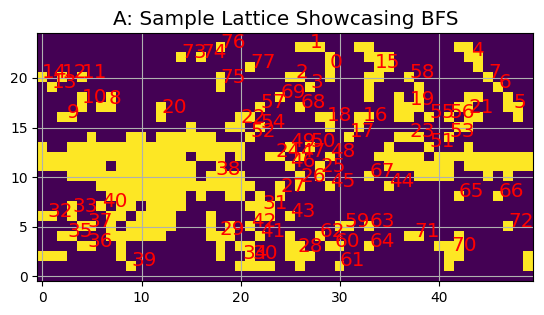

total number of clusters = 78

average size of clusters = 4.42308 std = 19.1006

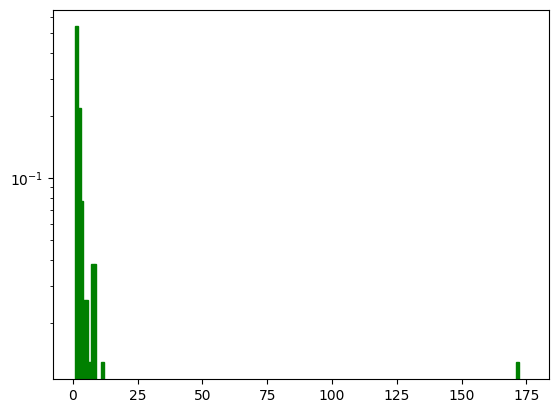

Initializing simulation from file file_output/fields_poiseuille_50_25_1.6_100_20_300.00_350.00seed3179.h5
Simulation with Poiseuille flow


torch.Size([345, 2])

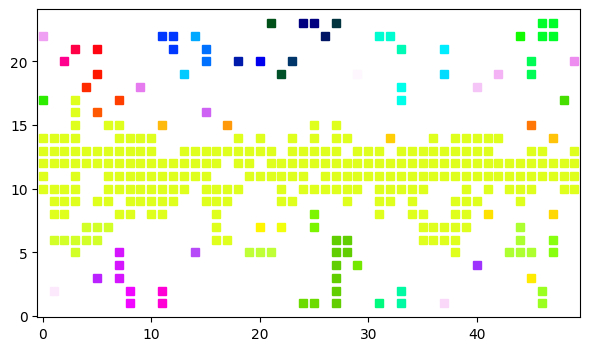

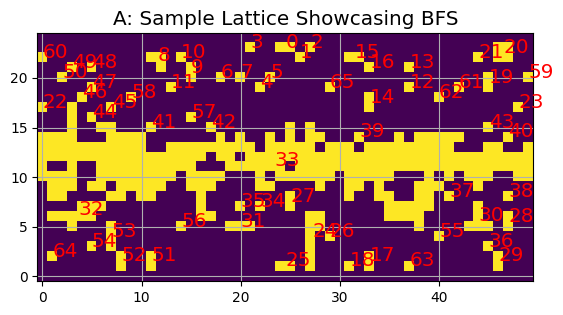

total number of clusters = 66

average size of clusters = 5.22727 std = 29.1557

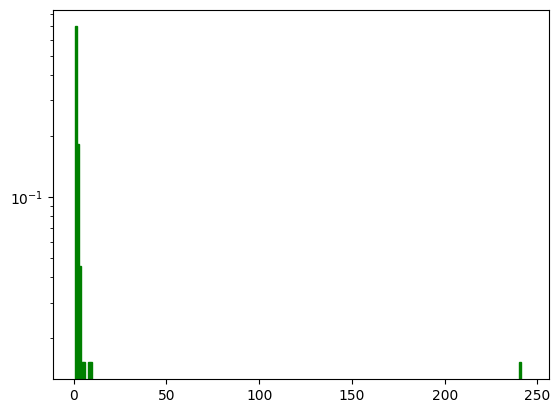

Initializing simulation from file file_output/fields_poiseuille_50_25_1.6_100_20_350.00_400.00seed3179.h5
Simulation with Poiseuille flow


torch.Size([345, 2])

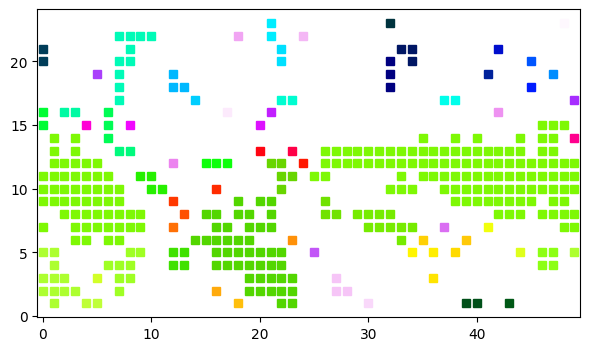

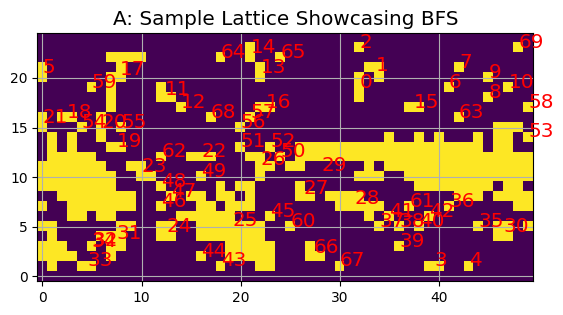

total number of clusters = 70

average size of clusters = 4.92857 std = 19.3585

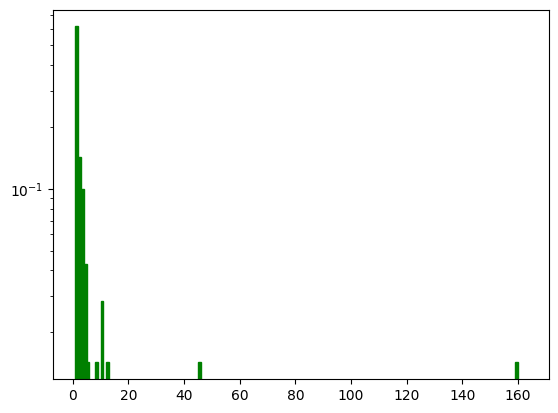

Initializing simulation from file file_output/fields_poiseuille_50_25_1.6_100_20_400.00_450.00seed3179.h5
Simulation with Poiseuille flow


torch.Size([345, 2])

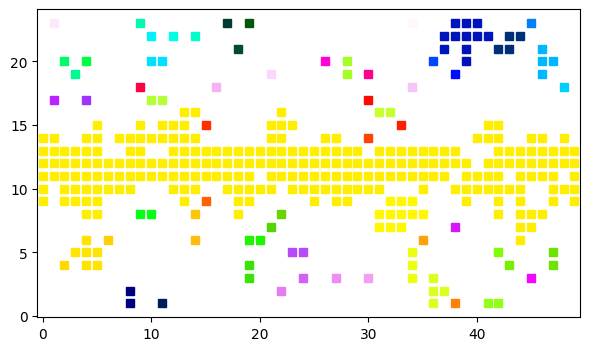

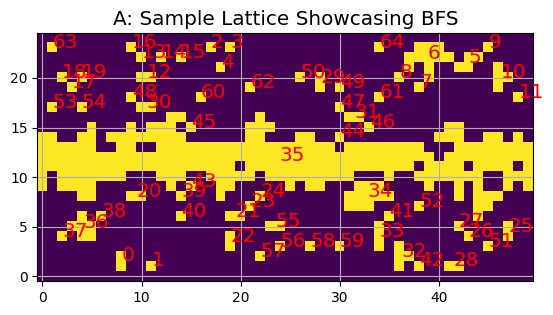

total number of clusters = 65

average size of clusters = 5.30769 std = 28.649

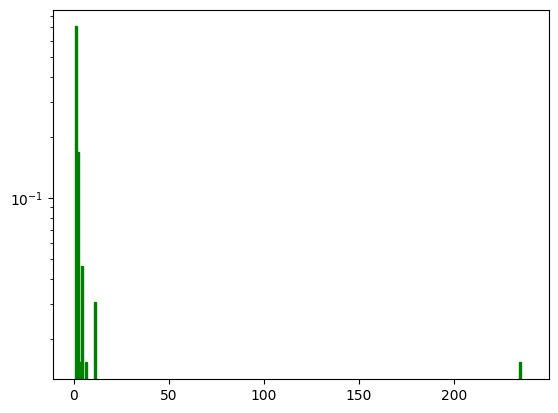

In [111]:
#lattice visualization 
for t in range(50,500,50):
    #clear_output(wait=True)
    lattice = read_lattice(t0 = t, tmax = 500, g = 1.6, v0 = 100., v1 = 20.)
    #print(lattice.visualize_lattice())
    data = torch.sum(lattice.particles, axis = 0)
    cutoff = 1.1 # Cut to dendrogram to obtain clusters at desired scale
    #lattice_params = {"sizeY": 6, "sizeX": 6}

    ''' Perform hierarchical clustering '''
    linkage_matrix, HCStats = detect_clusters(data=data, method='single', dendrogram_cutoff=cutoff)

    data_mX = HCStats[:,0]
    data_mY = HCStats[:,1]
    cluster_ids = HCStats[:,2]

    my_cmap = matplotlib.cm.get_cmap('gist_ncar')

    plt.figure(figsize = (7,4))

    for i in range(data_mX.shape[0]):
        col = my_cmap(cluster_ids[i]/(max(cluster_ids)))
        plt.plot(data_mX[i], data_mY[i],'s', color = col)

    plt.xlim(-0.5,49.5)
    plt.show()
    
    #time.sleep(1)
    
    data = torch.sum(lattice.particles, axis = 0)
    plt.imshow(data, origin='lower')
    plt.title("A: Sample Lattice Showcasing BFS", fontsize='x-large')
    plt.grid()

    cluster_ids = HCStats[:,-1]

    for cluster in np.unique(cluster_ids):
        X = HCStats[cluster_ids == cluster, 0]
        Y = HCStats[cluster_ids == cluster, 1]
        label_X = np.mean(X); label_Y = np.mean(Y)
        plt.text(x=label_X, y=label_Y, s="{}".format(cluster), color='red', fontsize='x-large')

    plt.xlim(-0.5,49.5)
    plt.show()
    
    
    unique_cluster_ids, sizes = np.unique(HCStats[:,-1], return_counts=True)
    print('total number of clusters = %d \n' %(len(unique_cluster_ids)))
    print('average size of clusters = %g std = %g \n' %(np.mean(sizes), np.std(sizes)))

    #distirbution of clusters size > threshold

    mask = ((sizes > 1))
    #print(mask * sizes)

    bins = (np.arange(1,max(sizes)+5, 1))
    hist, bins, = np.histogram(mask * sizes, bins = bins, density = True)
    #plt.plot(bins[:-1], hist, 'o-')
    plt.hist((mask * sizes), bins = bins, density = True, edgecolor = 'g', facecolor = 'g')

    #plt.xscale('log')
    plt.yscale('log')
    plt.show()

# Cluster analysis: 
1) measure the number of clusters in the lattice
2) measure the size of the clusters in the lattice

3) plot the  number of clusters, the mean size of the cluster, the standard deviation of the size  vs  time
4) save distribution of cluster size over time

In [146]:
def cluster_statistics(data): 
    ''' Perform hierarchical clustering '''
    linkage_matrix, HCStats = detect_clusters(data = data, method='single', dendrogram_cutoff=cutoff)

    data_mX = HCStats[:,0]
    data_mY = HCStats[:,1]
    cluster_ids = HCStats[:,2]
    unique_cluster_ids, sizes = np.unique(HCStats[:,-1], return_counts=True)
    #print('total number of clusters = %d \n' %(len(unique_cluster_ids)))
    #print('average size of clusters = %g std = %g \n' %(np.mean(sizes), np.mean(sizes)))
    
    mask_less1 = (sizes != 1)
    mask_less123 = (sizes > 3)
    mask_lessmax = (sizes != max(sizes))
    
    unique_cluster_ids_less1 = unique_cluster_ids * mask_less1
    unique_cluster_ids_less123 = unique_cluster_ids * mask_less123
    unique_cluster_ids_filtered1 = [element for element in unique_cluster_ids_less1 if element != 0]
    unique_cluster_ids_filtered123 = [element for element in unique_cluster_ids_less123 if element != 0]
    
    return len(unique_cluster_ids), np.mean(sizes), np.std(sizes), max(sizes), np.std(sizes*mask_lessmax), len(unique_cluster_ids_filtered1), len(unique_cluster_ids_filtered123)

In [156]:
num_clusters_t = []
mean_size_t = []
std_size_t = []
max_size_t = []
restricted_std_size_t = []
num_clusters_less_size1_t = []
num_clusters_less_size123_t = []

for t in range(50,500,50):
    lattice = read_lattice(t0 = t, tmax = 500, g = 0.4, v0 = 100., v1 = 20.)
    data = torch.sum(lattice.particles, axis = 0)
    cutoff = 1.1 # Cut to dendrogram to obtain clusters at desired scale

    num_clusters , mean_size, std_size, max_size, restricted_std_size,num_clusters_less_size1,num_clusters_less_size123 = cluster_statistics(data)
    num_clusters_t.append(num_clusters)
    mean_size_t.append(mean_size)
    std_size_t.append(std_size)
    max_size_t.append(max_size)
    restricted_std_size_t.append(restricted_std_size)
    num_clusters_less_size1_t.append(num_clusters_less_size1)
    num_clusters_less_size123_t.append(num_clusters_less_size123)

Initializing simulation from file file_output/fields_poiseuille_50_25_0.4_100_20_0.00_50.00seed3179.h5
Simulation with Poiseuille flow


torch.Size([345, 2])

Initializing simulation from file file_output/fields_poiseuille_50_25_0.4_100_20_50.00_100.00seed3179.h5
Simulation with Poiseuille flow


torch.Size([345, 2])

Initializing simulation from file file_output/fields_poiseuille_50_25_0.4_100_20_100.00_150.00seed3179.h5
Simulation with Poiseuille flow


torch.Size([345, 2])

Initializing simulation from file file_output/fields_poiseuille_50_25_0.4_100_20_150.00_200.00seed3179.h5
Simulation with Poiseuille flow


torch.Size([345, 2])

Initializing simulation from file file_output/fields_poiseuille_50_25_0.4_100_20_200.00_250.00seed3179.h5
Simulation with Poiseuille flow


torch.Size([345, 2])

Initializing simulation from file file_output/fields_poiseuille_50_25_0.4_100_20_250.00_300.00seed3179.h5
Simulation with Poiseuille flow


torch.Size([345, 2])

Initializing simulation from file file_output/fields_poiseuille_50_25_0.4_100_20_300.00_350.00seed3179.h5
Simulation with Poiseuille flow


torch.Size([345, 2])

Initializing simulation from file file_output/fields_poiseuille_50_25_0.4_100_20_350.00_400.00seed3179.h5
Simulation with Poiseuille flow


torch.Size([345, 2])

Initializing simulation from file file_output/fields_poiseuille_50_25_0.4_100_20_400.00_450.00seed3179.h5
Simulation with Poiseuille flow


torch.Size([345, 2])

<ErrorbarContainer object of 3 artists>

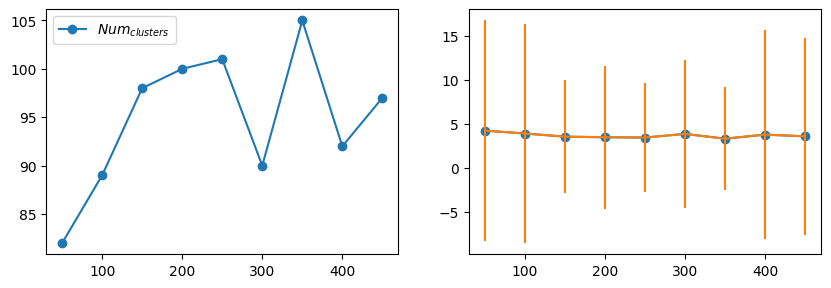

In [157]:
plt.figure(figsize = (10,7))

plt.subplot(2,2,1)
plt.plot([t for t in range(50,500,50)], num_clusters_t, 'o-', label = r'$Num_{clusters}$')
plt.legend()

#plt.subplot(2,2,2)
#plt.plot([t for t in range(50,500,50)], num_clusters_less_size1_t, 'o-', label = r'$Num_{clusters}$ less ones of size 1')
#plt.legend()

#plt.subplot(2,2,3)
#plt.plot([t for t in range(50,500,50)], num_clusters_less_size123_t, 'o-', label = r'$Num_{clusters}$ less ones of size 1,2,3')
#plt.legend()

plt.subplot(2,2,2)
plt.plot([t for t in range(50,500,50)], mean_size_t, 'o-')
plt.errorbar([t for t in range(50,500,50)], mean_size_t, yerr = std_size_t)
#plt.ylim(0,100)
#plt.legend()

#plt.subplot(2,2,3)
#plt.plot([t for t in range(50,500,50)], max_size_t, 'o-', label = 'max cluster size in the lattice')
#plt.legend()

#plt.subplot(2,2,4)
#plt.plot([t for t in range(50,500,50)], std_size_t, 'o-', label = 'std of cluster size')
#plt.legend()
